Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in the gravitational-wave class; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course, careful with overfitting here).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.
- Plot ROC curves
- **Important** Don't use `snr` as feature in your classifer (that's the answer...)



In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from matplotlib import colors

from sklearn.linear_model import LogisticRegression
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from sklearn.preprocessing import StandardScaler

In [2]:
data = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
list(data.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [3]:
np.shape(data['snr'])

N = 10000

iota = data['iota'][:N]
snr = data['snr'][:N]
mtot= data['mtot'][:N]
q = data['q'][:N]
z = data['z'][:N]
psi = data['psi'][:N]
det =  data['det'][:N] #detectability

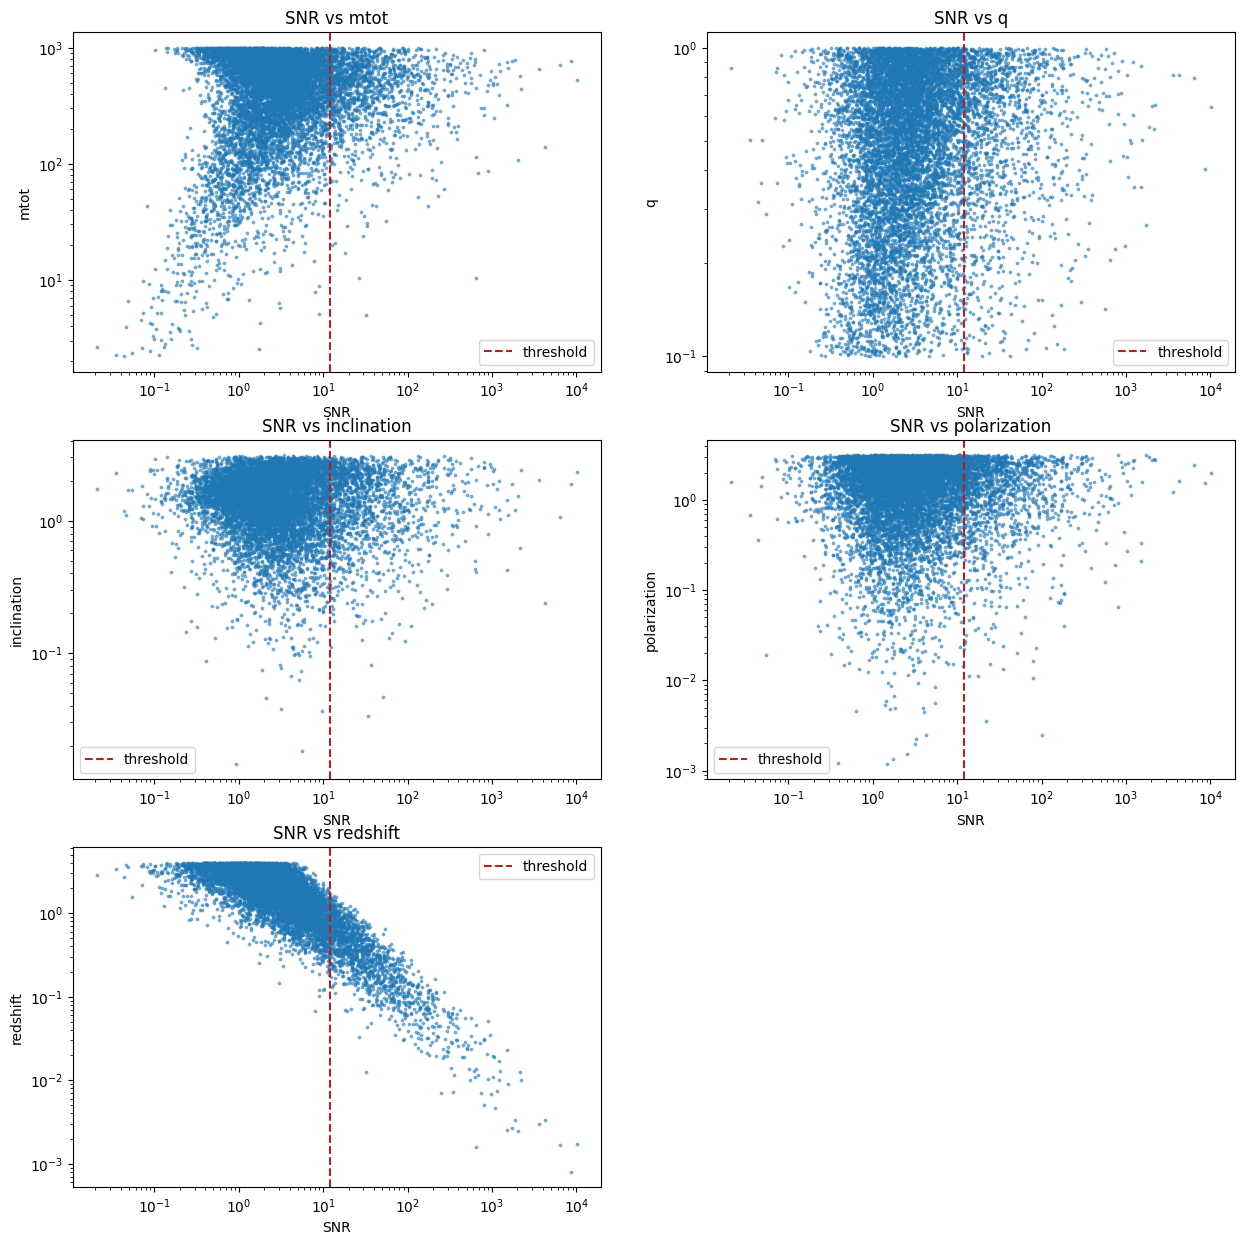

In [4]:
#take a look at the data 
features = [mtot, q, iota, psi, z]
titles = ['mtot', 'q', 'inclination', 'polarization', 'redshift' ]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, (var, title) in enumerate(zip(features, titles)):
    ax = axes[i]
    ax.scatter(snr, var, alpha=0.5, s = 3)
    ax.axvline(x=12, color='firebrick', linestyle='--', label = 'threshold')
    ax.set_xlabel('SNR')
    ax.set_ylabel(title)
    ax.set_title(f'SNR vs {title}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()

fig.delaxes(axes[-1])

looks like the redshift is the most important feature to take into account (have the most variability within the data)

In [31]:
# dividing my data 
X = np.array([mtot, q, iota, psi, z]).T
y = det #0 or 1
scaler = StandardScaler() #normalization
X = scaler.fit_transform(X)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=43)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")



Training set size: 7500
Test set size: 2500



Modello:\
La regressione logistica calcola una **combinazione lineare** delle feature:

$z_i = w_0 + w_1 \cdot \text{mtot}_i + w_2 \cdot q_i + w_3 \cdot \iota_i + w_4 \cdot \psi_i + w_5 \cdot z_i$


Funzione di attivazione (Sigmoid)
Trasforma il valore lineare in una probabilità:

$
P(y_i = 1) = \frac{1}{1 + e^{-z_i}}
$


Decisione:
$
\hat{y}_i =
\begin{cases}
1 & \text{se } P(y_i=1) \geq 0.5 \\
0 & \text{altrimenti}
\end{cases}
$

---

Addestramento:
- Si cercano i pesi \( w \) e il bias \( w_0 \) che **minimizzano la log-loss**:
$
  L = - \sum_i [y_i \log(p_i) + (1 - y_i)\log(1 - p_i)]
$
- L’ottimizzazione usa metodi numerici (es. *gradient descent*).


completeness: 0.9318801089918256
contamination: 0.41737649063032367


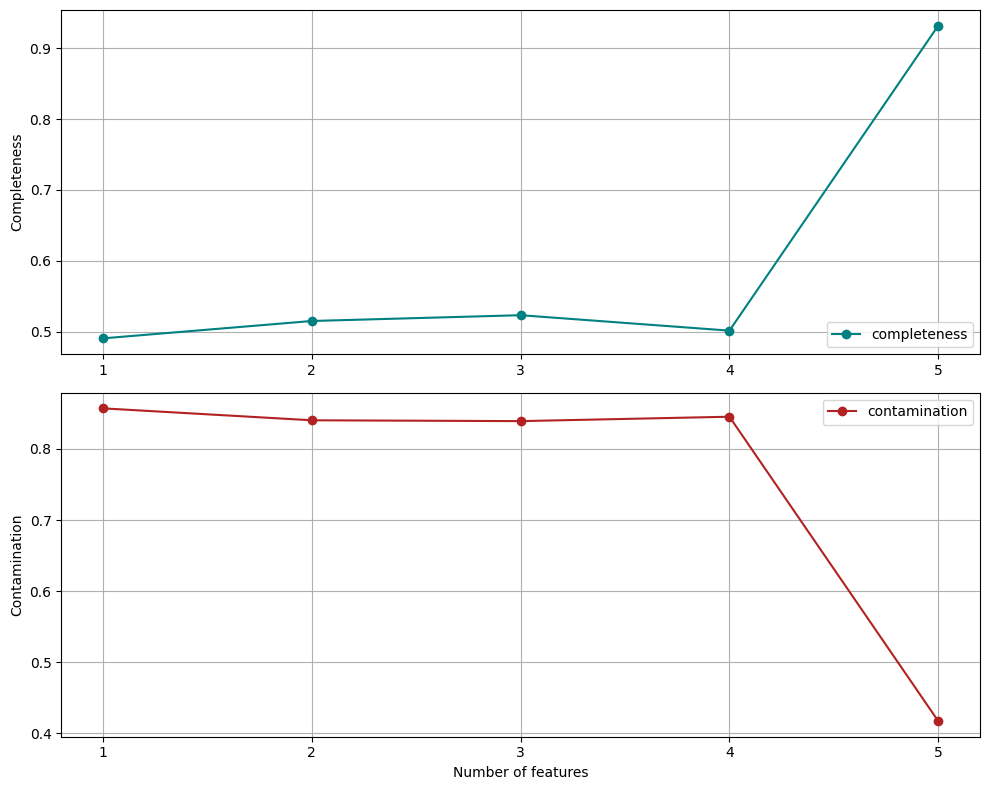

In [22]:
from sklearn.linear_model import LogisticRegression
from astroML.utils import completeness_contamination

n_features = np.arange(1, X.shape[1] + 1)

completeness = []
contamination = []

for nc in n_features:
    clf = LogisticRegression(class_weight='balanced') #automatically adjust weights for each class inversely proportional to class frequencies in the training data.
    clf.fit(X_train[:, :nc], y_train)      #Durante la fase di training, l’algoritmo penalizza di più gli errori fatti sulla classe minoritaria
    y_pred = clf.predict(X_test[:, :nc])

    comp, cont = completeness_contamination(y_pred, y_test)
    completeness.append(comp)
    contamination.append(cont)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(n_features, completeness, 'o-',c = 'teal', ms=6, label = 'completeness')
ax[0].set_ylabel('Completeness')
ax[0].set_xticks(n_features)
ax[0].grid(True)
ax[0].legend(loc = 'lower right')

ax[1].plot(n_features, contamination, 'o-',c = 'firebrick', ms=6, label = 'contamination')
ax[1].set_xlabel('Number of features')
ax[1].set_ylabel('Contamination')
ax[1].set_xticks(n_features)
ax[1].grid(True)
ax[1].legend()

print('completeness:', completeness[-1])
print('contamination:', contamination[-1])

plt.tight_layout()
plt.show()

as expected, the most importatnt feature is the redshift

Train size:  750 | Train RMS: 0.3425 | Test RMS: 0.3329
Train size: 1500 | Train RMS: 0.3386 | Test RMS: 0.3335
Train size: 2250 | Train RMS: 0.3232 | Test RMS: 0.3231
Train size: 3000 | Train RMS: 0.3256 | Test RMS: 0.3256
Train size: 3750 | Train RMS: 0.3254 | Test RMS: 0.3256
Train size: 4500 | Train RMS: 0.3249 | Test RMS: 0.3274
Train size: 5250 | Train RMS: 0.3240 | Test RMS: 0.3274
Train size: 6000 | Train RMS: 0.3233 | Test RMS: 0.3268
Train size: 6750 | Train RMS: 0.3243 | Test RMS: 0.3274
Train size: 7500 | Train RMS: 0.3225 | Test RMS: 0.3286


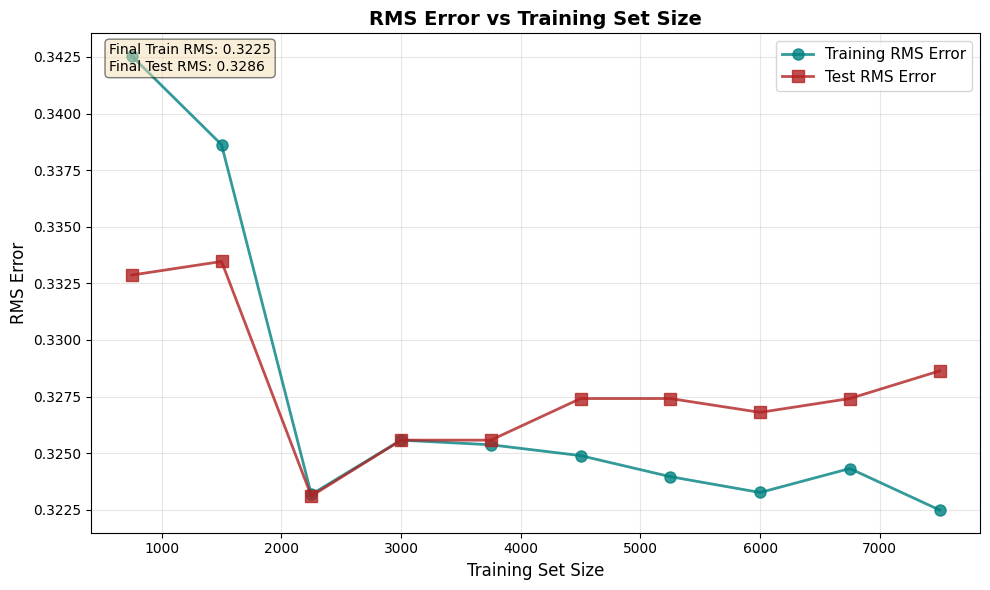


=== Final Results ===
Training RMS Error: 0.3225
Test RMS Error: 0.3286


In [23]:

#Train the model with increasing amounts of training data (from 10% to 100%)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Define different training sizes (as percentages or absolute numbers)
# Option 1: Use percentages of total training data
train_sizes = np.linspace(0.1, 1.0, 10)  # From 10% to 100% of training data

accuracy_train = []
accuracy_test = []
rms_train = []
rms_test = []

for size in train_sizes:
    # Calculate actual number of samples
    n_samples = int(size * len(X_train))
    
    # Train with subset of data
    clf = LogisticRegression(class_weight='balanced', max_iter=1000)#increase the standard limit of 100 iteration
    clf.fit(X_train[:n_samples], y_train[:n_samples])
    
    # Predict on train and test sets
    y_train_pred = clf.predict(X_train[:n_samples])
    y_test_pred = clf.predict(X_test)

    #accuracy calculation
    accuracy_train.append(accuracy_score(y_train[:n_samples],y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))
                    
    
    # Calculate RMS error (Root Mean Squared Error)
    rms_train_error = np.sqrt(mean_squared_error(y_train[:n_samples], y_train_pred))
    rms_test_error = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    rms_train.append(rms_train_error)
    rms_test.append(rms_test_error)
    
    print(f"Train size: {n_samples:4d} | Train RMS: {rms_train_error:.4f} | Test RMS: {rms_test_error:.4f}")

# Convert train_sizes to actual sample counts for plotting
actual_train_sizes = (train_sizes * len(X_train)).astype(int)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(actual_train_sizes, rms_train, 'o-', c='teal', ms=8, linewidth=2, 
        label='Training RMS Error', alpha=0.8)
ax.plot(actual_train_sizes, rms_test, 's-', c='firebrick', ms=8, linewidth=2, 
        label='Test RMS Error', alpha=0.8)

ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('RMS Error', fontsize=12)
ax.set_title('RMS Error vs Training Set Size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)

# Add text with final values
final_text = f'Final Train RMS: {rms_train[-1]:.4f}\nFinal Test RMS: {rms_test[-1]:.4f}'
ax.text(0.02, 0.98, final_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print('\n=== Final Results ===')
print(f'Training RMS Error: {rms_train[-1]:.4f}')
print(f'Test RMS Error: {rms_test[-1]:.4f}')



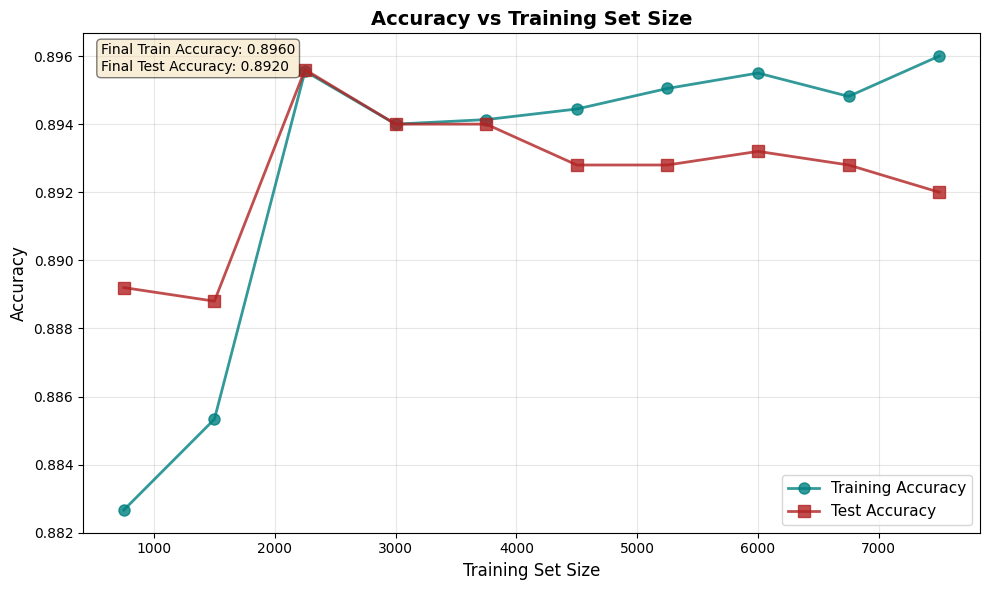


=== Final Results ===
Training Accuracy: 0.8960
Test Accuracy: 0.8920


In [24]:
# plot accuracy
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(actual_train_sizes, accuracy_train, 'o-', c='teal', ms=8, linewidth=2, 
        label='Training Accuracy', alpha=0.8)
ax.plot(actual_train_sizes, accuracy_test, 's-', c='firebrick', ms=8, linewidth=2, 
        label='Test Accuracy', alpha=0.8)

ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy vs Training Set Size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)

# Add text with final values
final_text = f'Final Train Accuracy: {accuracy_train[-1]:.4f}\nFinal Test Accuracy: {accuracy_test[-1]:.4f}'
ax.text(0.02, 0.98, final_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print('\n=== Final Results ===')
print(f'Training Accuracy: {accuracy_train[-1]:.4f}')
print(f'Test Accuracy: {accuracy_test[-1]:.4f}')


overfitting start?

## Logistic regression with hyperparameters tuning

In [40]:
# finds the best hyperparameters for Logistic Regression with cross-validation

from sklearn.model_selection import GridSearchCV
from astroML.utils import completeness_contamination

# Define the parameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Only solver that works with both L1 and L2 penalties
}#solver is the algorithm that performs the optimization of the weights (coefficients) in logistic regression

# Create GridSearchCV object
grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced'),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,  # Show progress
    n_jobs=-1  # Use all available CPU cores
)

# Fit the grid search
print("Starting Grid Search...")
grid_search.fit(X_train, y_train) #Trains models for every combination in param_grid

# Get the best model
best_log_reg = grid_search.best_estimator_ #gives the model with highest CV accuracy.

# Print results
print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
print("="*60)

# Display all results sorted by performance
import pandas as pd
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[['param_C', 'param_penalty', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.sort_values('rank_test_score')
print("\nAll parameter combinations (sorted by performance):")
print(results_df.to_string(index=False))

# Evaluate on test set
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)
y_pred = best_log_reg.predict(X_test)
completeness, contamination = completeness_contamination(y_pred, y_test)

print(f"Completeness: {completeness:.4f}")
print(f"Contamination: {contamination:.4f}")

# Additional test metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
#test_f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print("="*60)



Starting Grid Search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

GRID SEARCH RESULTS
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.8939

All parameter combinations (sorted by performance):
 param_C param_penalty  mean_test_score  std_test_score  rank_test_score
   10.00            l1         0.893867        0.006659                1
   10.00            l2         0.893867        0.006659                1
  100.00            l1         0.893867        0.006659                1
  100.00            l2         0.893867        0.006659                1
    1.00            l1         0.893733        0.007038                5
    1.00            l2         0.892133        0.007488                6
    0.10            l1         0.889067        0.007804                7
    0.10            l2         0.881067        0.007298                8
    0.01            l1         0.856267        0.005571                9
    0

As axpected the prefered regularization method is the LASSO beacouse it can set the weight of unusefull features to zero.\
C molto alto aspettato pechè il modello non sembrava stesse molto overfittando. L1 comunque utile per fare feaure seloction.

ROC AUC Score: 0.9764


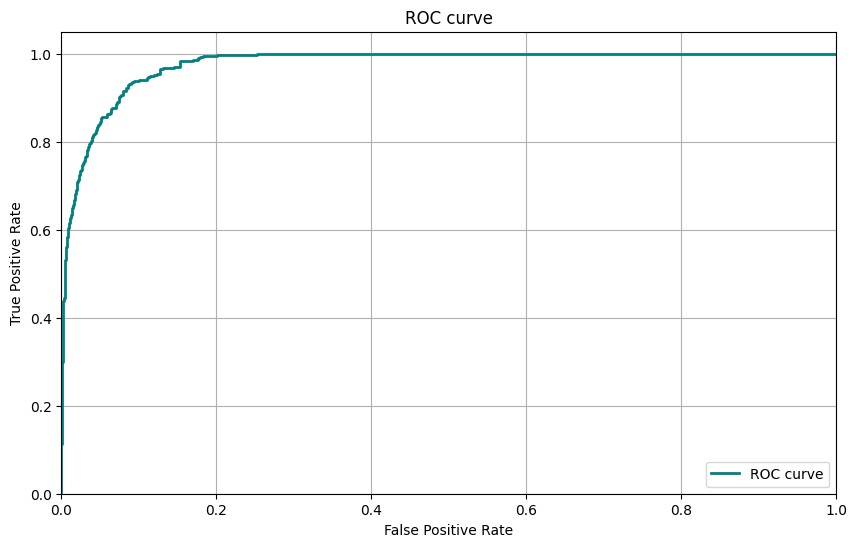

In [41]:
from sklearn.metrics import roc_curve, auc
# Get prediction probabilities for ROC curve
y_pred_proba = best_log_reg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  #J = TPR - FPR = Sensitivity - (1 - Specificity)
roc_auc = auc(fpr, tpr) #AREA UNDER THE CURVE
print(f"ROC AUC Score: {roc_auc:.4f}")
print("="*60)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='teal', lw=2, label=f'ROC curve')
plt.xlim([0.0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Support Vector Machine (SVM) con Grid Search

-Modello base: Support Vector Machine (SVC):\
L’SVM cerca di **trovare l’iperpiano** che separa al meglio le due classi nel **feature space**.


$
f(x) = \sum_i \alpha_i y_i K(x_i, x) + b
$

-Decisione finale:\
$
\hat{y} =
\begin{cases}
1 & \text{se } f(x) \geq 0 \\
0 & \text{altrimenti}
\end{cases}
$


-Kernel:
Il **kernel** trasforma i dati in uno spazio di dimensione più alta, per rendere possibile una separazione lineare.

- `'linear'` → separazione lineare nello spazio originale  
- `'rbf'` → separazione non lineare usando funzioni gaussiane  

$
K(x_i, x_j) =
\begin{cases}
x_i^\top x_j & \text{(linear)} \\
\exp(-\gamma \|x_i - x_j\|^2) & \text{(rbf)}
\end{cases}
$

---

-Parametri principali

| Parametro | Descrizione |
|------------|-------------|
| `C` | Controlla la **regolarizzazione** (quanto penalizzare errori sul training set) |
| `kernel` | Tipo di funzione kernel (es. `'linear'`, `'rbf'`) |
| `gamma` | Coefficiente per kernel RBF: controlla la "larghezza" della gaussiana |
| `probability=True` | Calcola probabilità per metriche come ROC-AUC |



In [42]:
from sklearn.svm import SVC

# dividing my data 
X = np.array([mtot, q, iota, psi, z]).T
y = det #0 or 1
scaler = StandardScaler() #normalization
X = scaler.fit_transform(X)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 7500
Test set size: 2500


In [43]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient: scale= 1/(number of features); auto 1/(5*var_media delle features dopo lo scaling)
}

In [44]:
# Create GridSearchCV
grid_search = GridSearchCV(
    SVC(random_state=42, probability=True),  
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best model
best_svm = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [45]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9577


In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions
y_pred = best_svm.predict(X_test)
y_pred_proba = best_svm.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
#test_f1 = f1_score(y_test, y_pred)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Completeness and contamination
completeness = tp / (tp + fn) if (tp + fn) > 0 else 0
contamination = fp / (tp + fp) if (tp + fp) > 0 else 0

# Print results
print(f"Accuracy:      {test_accuracy:.4f}")
print(f"Precision:     {test_precision:.4f}")
print(f"Recall:        {test_recall:.4f}")
print(f"Completeness:  {completeness:.4f}")
print(f"Contamination: {contamination:.4f}")

Accuracy:      0.9560
Precision:     0.8646
Recall:        0.8369
Completeness:  0.8369
Contamination: 0.1354


è diminuita un pochino la completeness ma la contamination si è abbassata molto

ROC AUC Score: 0.9886


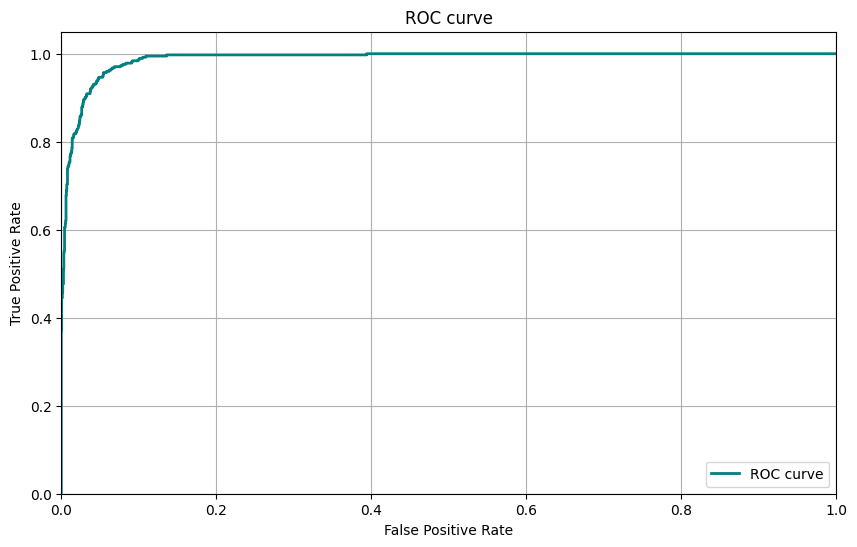

In [47]:
# ROC AUC #AREA UNDER THE CURVE
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='teal', lw=2, label=f'ROC curve')
plt.xlim([0.0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()